# Deep Learning: Multi-class classification

This notebook is part of the MOOC fast.ai DL1 ([source](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb))

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data


*topics:*  
    - transfer learning  
    - progressive resizing  
    - leaning rate scheduler  
    - imagenet normalization  
    - datablock API  
    - ...?  
    

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#! conda update -v -y -c fastai fastai

We first import the fastai [vision module](https://docs.fast.ai/vision.html).

In [3]:
from fastai.vision import *

In [6]:
# set a random seed
np.random.seed(42)

# Multi-label classification
Contrary to the dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [4]:
path = Path('/data/ifu/summerschool/original.datasets/kaggle.planet-amazon')
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a DataBunch while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

Next, we define **tranformations** for **data augmentation**. This will make out model stronger as we create new (and different) traing data. We specify that we allow vertical flips, lightning changes, a slight zoom, but no warping. See the [documentation of transformations](https://docs.fast.ai/vision.transform.html#List-of-transforms) for details what is possible. 

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Next we build an `ImageList` (which is a specicial form of an `ItemList`). The list is built up using a csv file that contains the filenames (thus we use the `from_csv` method). We then split the files into training (80%) and validation (20%) subsets using `split_by_rand_pct(0.2)`. In the last segment the items are labeled from information of the DataFrame.  

The file describing the traingin data look like this:  

> ```raw
> head -n train_v2.csv
>
> image_name,tags
> train_0,haze primary
> train_1,agriculture clear primary water
> ```

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In the next step we apply the transformations we defined above, we specify that we want the images scaled to 128x128px, to convert them into a `databunch` and to finally normalize the data with the imagenet_stats (as we are going to use a pretrained model that was fed ImageNet data we need to use the characteristics of the imagenet dataset - since they are widely used these come prepackaged as constants with the fastai module).  

**TODO:** explain the DataBunch object

In [69]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

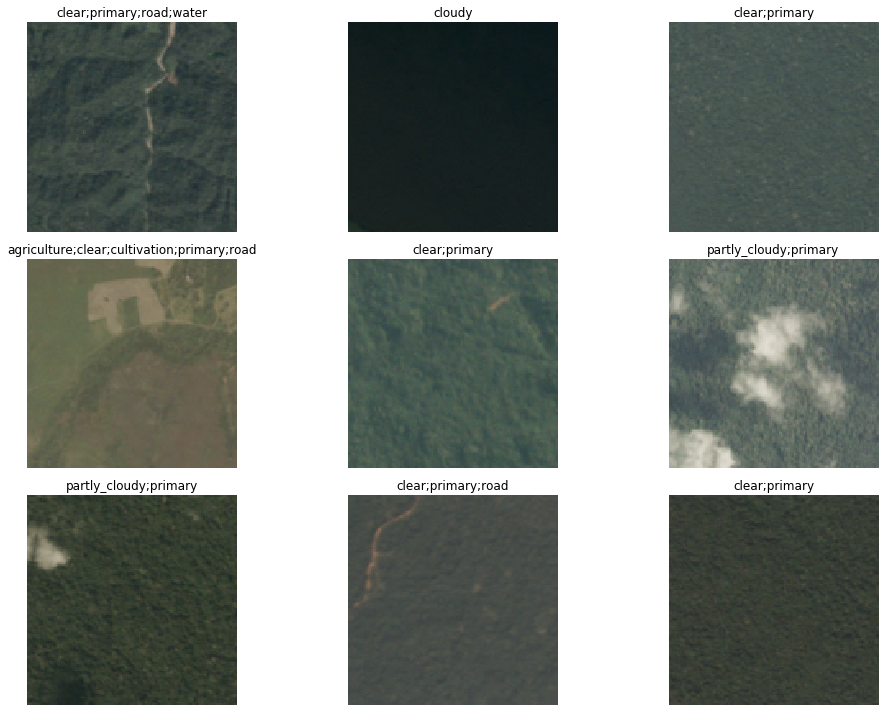

In [80]:
data.show_batch(rows=3, figsize=(14,10))

To create a `Learner` we use the same function as in lesson 1 (**TODO: fix/ change to our lesson1)**).
Our base architecture is resnet50 again, but the metrics are a little bit different: we use 
[`accuracy_thresh`](https://docs.fast.ai/metrics.html#accuracy_thresh) instead of [`accuracy`](https://docs.fast.ai/metrics.html#accuracy). In lesson 1, we determined the predicition for a given
class by picking the final activation that was the biggest, but here, each activation can be 0 or 1
`accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares
them to the ground truth.

As for [Fbeta](https://docs.fast.ai/metrics.html#fbeta), it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

$$ {F_\beta} = (1+\beta^2)\frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall} $$

**TODO: fix lesson 1 and double check reference here**

Next, we define the CNN model architecture since we will reuse the powerful [ResNet50](https://arxiv.org/pdf/1512.03385) model utilizing [transfer learning](https://docs.fast.ai/vision.learner.html#Transfer-learning). 

In [11]:
arch = models.resnet50

Now we create the [`learner`](https://docs.fast.ai/vision.learner.html) by using the convenience method `cnn_learner`. We pass the `databunch` we created, the ResNet50 model architecture, and two [metrics](https://docs.fast.ai/metrics.html#Predefined-metrics) (accuracy threshold, fbeta). 

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 17.7MB/s]


We use the LR Finder to pick a good learning rate.

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


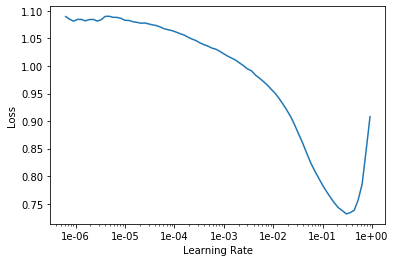

In [14]:
learn.recorder.plot()

Then we can fit the head of our network.

In [15]:
lr = 0.01

In [16]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.134040,0.118407,0.948080,0.895948,00:35
1,0.114980,0.100252,0.952171,0.908311,00:35
2,0.100527,0.092790,0.951241,0.916544,00:35
3,0.096924,0.088180,0.957083,0.923496,00:35
4,0.090542,0.086935,0.956647,0.924431,00:35


In [17]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


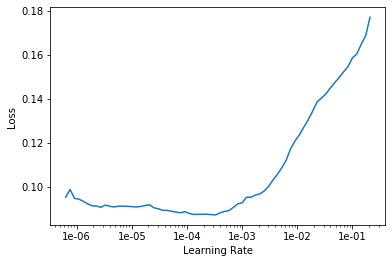

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095403,0.091577,0.953828,0.920770,00:47
1,0.094971,0.089847,0.955615,0.920811,00:48
2,0.092610,0.086980,0.959314,0.924846,00:48
3,0.083957,0.083427,0.957032,0.927520,00:49
4,0.080740,0.082744,0.958413,0.928377,00:49


In [21]:
learn.save('stage-2-rn50')

In [22]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [23]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


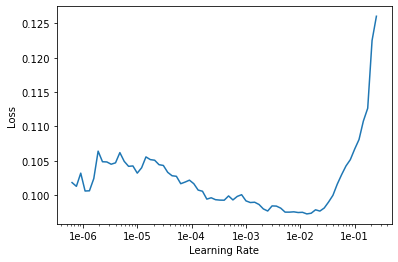

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr=1e-2/2

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087175,0.085147,0.957374,0.926875,02:01
1,0.088676,0.084325,0.956655,0.925775,02:02
2,0.085821,0.082417,0.957425,0.928755,02:02
3,0.082707,0.081336,0.959059,0.930560,02:02
4,0.080352,0.080898,0.959045,0.931180,02:02


In [27]:
learn.save('stage-1-256-rn50')

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.081751,0.083704,0.954729,0.925502,02:42
1,0.086703,0.083147,0.958595,0.929852,02:42
2,0.082713,0.083152,0.958987,0.927075,02:43
3,0.075442,0.080859,0.959539,0.930620,02:43
4,0.076304,0.080665,0.959227,0.930316,02:43


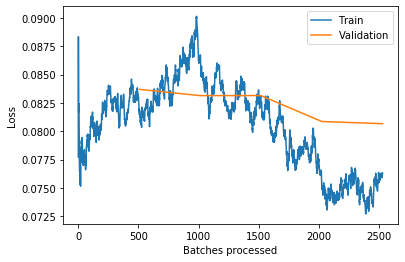

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save('stage-2-256-rn50')

In [32]:
learn.export()

In [33]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [34]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [35]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [36]:
labelled_preds[:5]

['agriculture clear primary road water',
 'agriculture clear cultivation primary',
 'agriculture clear cultivation primary',
 'clear primary water',
 'clear primary']

In [37]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [39]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [40]:
df.head()

,image_name,tags
0,test_25935,agriculture clear primary road water
1,test_34341,agriculture clear cultivation primary
2,test_21244,agriculture clear cultivation primary
3,test_35673,clear primary water
4,test_3615,clear primary


image_name                              test_25935
tags          agriculture clear primary road water
Name: 0, dtype: object

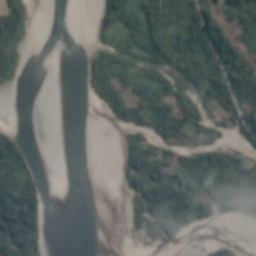

image_name                               test_34341
tags          agriculture clear cultivation primary
Name: 1, dtype: object

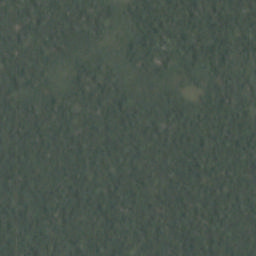

image_name                               test_21244
tags          agriculture clear cultivation primary
Name: 2, dtype: object

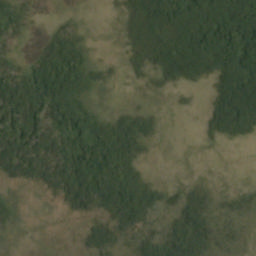

image_name             test_35673
tags          clear primary water
Name: 3, dtype: object

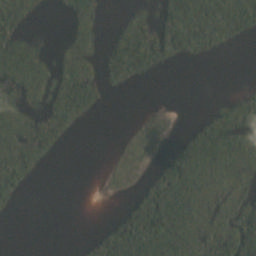

image_name        test_3615
tags          clear primary
Name: 4, dtype: object

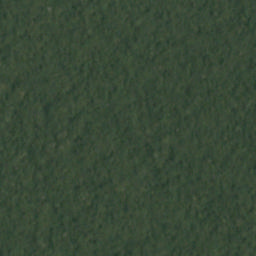

image_name       test_30937
tags          clear primary
Name: 5, dtype: object

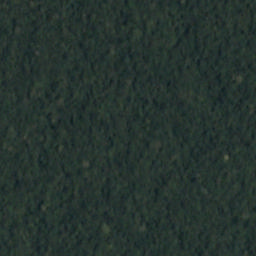

image_name                                           test_37931
tags          agriculture clear cultivation habitation partl...
Name: 6, dtype: object

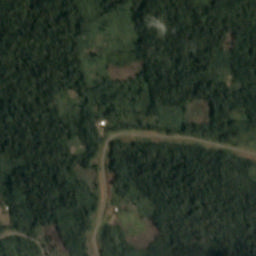

image_name       test_23680
tags          clear primary
Name: 7, dtype: object

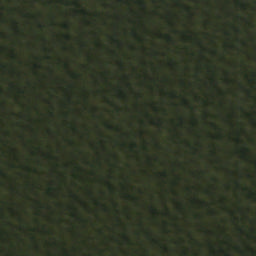

image_name                               test_20835
tags          agriculture clear cultivation primary
Name: 8, dtype: object

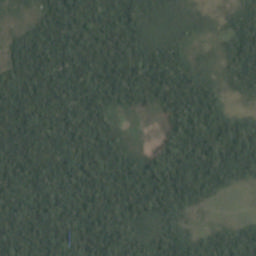

In [64]:
for i in range(9):
    display(df.iloc[i], learn.data.test_ds.open( learn.data.test_ds.items[i]) )